In [ ]:
import torch
import open_clip
from PIL import Image
import matplotlib.pyplot as plt

import intel_extension_for_pytorch as ipex

In [3]:
model_id = 'ViT-B-32'

In [3]:
model_id = 'ViT-L-14'

In [ ]:
model_id = 'ViT-H-14'

In [ ]:
model_id = 'ViT-g-14'

In [4]:
pretrained_path = f"../checkpoints/open_clip_{model_id.lower().replace('-','_')}.pth"

In [5]:
pretrained_path

'../checkpoints/open_clip_vit_l_14.pth'

In [6]:
model, _, preprocess = open_clip.create_model_and_transforms(model_id, pretrained=pretrained_path)

2023-10-31 17:18:35,953 - root - INFO - Loaded ViT-L-14 model config.
2023-10-31 17:18:38,935 - root - INFO - Loading pretrained ViT-L-14 weights (../checkpoints/open_clip_vit_l_14.pth).


In [7]:
tokenizer = open_clip.get_tokenizer(model_id)

In [8]:
image_pil = Image.open('assets/cat_dog.jpeg')
image = preprocess(image_pil).unsqueeze(0)

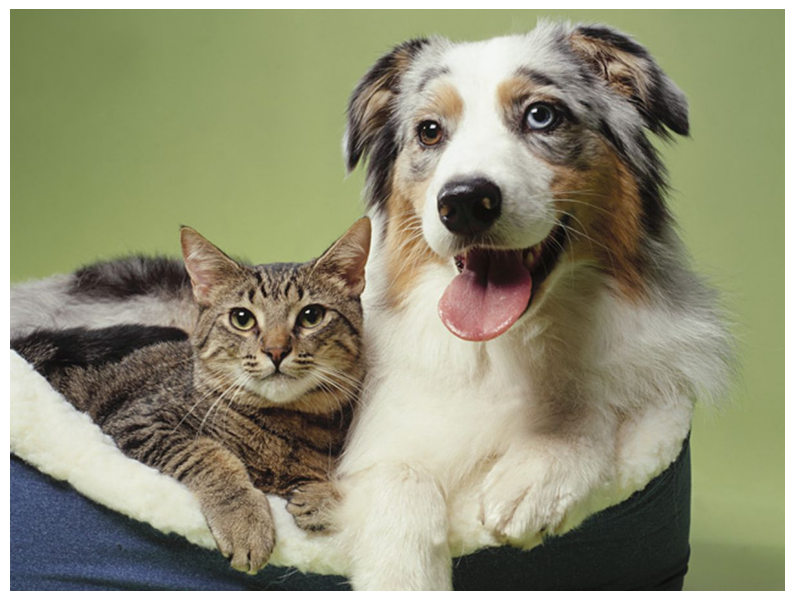

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image_pil)
plt.axis('off')
plt.show()

In [9]:
_ = model.eval()

In [10]:
device = torch.device('xpu')

In [11]:
model = model.to(device)

In [12]:
model = ipex.optimize(model)

/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


In [13]:
image = image.to(device)

In [11]:
text = tokenizer(['a cat']).to(device)

In [15]:
_ = model.encode_image(image)
_ = model.encode_text(text)

In [17]:
%timeit model.encode_image(image)

26.7 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit model.encode_text(text)

13.6 ms ± 74.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
model = model.half().to(device)
model = ipex.optimize(model)

/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


In [13]:
image = image.half().to(device)

In [14]:
%timeit model.encode_image(image)

22.2 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit model.encode_text(text)

12.1 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
def infer(model, image, token):
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
        return (100.0 * image_features @ text_features.T).softmax(dim=-1)

In [27]:
text = tokenizer(['a hawk', 'a cat', 'a dog']).to(device)

In [28]:
probs = infer(model, image, text)

In [29]:
probs = probs.cpu().numpy()

In [30]:
probs

array([[1.31e-06, 6.15e-01, 3.85e-01]], dtype=float16)

In [31]:
p = [ x for x in probs[0] ]

In [32]:
p

[1.3e-06, 0.615, 0.385]

In [12]:
%timeit -n 10 -r 30 infer(model, image, text)

13.4 ms ± 183 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [33]:
text = tokenizer(['a dog', 'a cat']).to(device)

In [34]:
infer(model, image, text)

tensor([[0.3811, 0.6187]], device='xpu:0', dtype=torch.float16)

In [35]:
text = tokenizer(['a dog and a cat']).to(device)
infer(model, image, text)

tensor([[1.]], device='xpu:0', dtype=torch.float16)

In [28]:
image_pil = Image.open('assets/demo2.jpg')
image = preprocess(image_pil).unsqueeze(0).to(device)
text = tokenizer(['a running dog']).to('xpu')

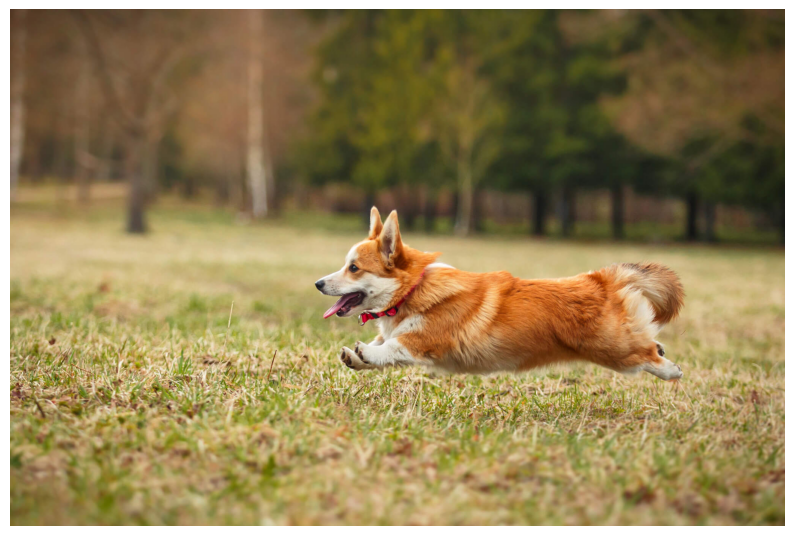

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image_pil)
plt.axis('off')
plt.show()

In [30]:
infer(model, image, text)

tensor([[1.]], device='xpu:0')

In [31]:
text = tokenizer(['grass land', 'dog', 'forest']).to('xpu')
infer(model, image, text)

tensor([[2.6741e-04, 9.9962e-01, 1.1429e-04]], device='xpu:0')